In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import matplotlib.pyplot as plt

In [34]:
from argparse import Namespace
from pathlib import Path
import torch
from pytorch_lightning.trainer import Trainer, seed_everything
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from turboflow.dataloaders import TurboFlowDataModule
from turboflow.evaluation import compute_all_metrics

from turboflow.utils import phy_utils as phy
from turboflow.utils import torch_utils as tch

In [35]:
seed_everything(42, workers=True)

Global seed set to 42


42

In [36]:
# load dataset
data_dir = Path('/','home','dicarlo_d','Documents','Datasets','Turb2D.hdf5')
dm = TurboFlowDataModule(dataset='Turb2D', 
                         data_dir=data_dir,
                         batch_size=100000,
                         time_idx=33,
                         train_downsampling=8,
                         val_downsampling=8,
                         test_downsampling=1,
                         num_workers=1)
dm.setup()

In [37]:
# choose the hyperparams
hparams = {
    'name':'RFFNet',
    'mlp_layers_num': 5,
    'mlp_layers_dim': 256, 
    'mlp_last_actfn': 'tanh',
    'do_rff': True, 
    'rff_num': 512, 
    'rff_scale': 10,
    'do_divfree': True,
    'lam_pde': 0,     # soft constr. grad(u,v)=0
    'lam_div': 0,     # spatial grad(u,v) = torch.autograd(u,v)
    'lam_reg': 0,     # offgrid L2 reg. on grad of the potential
    'lam_sfn': 0,     # offgrid L2 reg. on Sfun
    'lam_spec': 0,    # L2 diff on the spectrum
    'lam_grads':1,    # offrgid L2 reg. on grad and autograd
    'lam_weight': 0,  # L2 reg on the NN's weights
    'sfn_min_x': 0.00784314,
    'sfn_num_centers': 50,
    'sfn_num_increments':3,
    'sfn_patch_dim': 30
}

In [38]:
early_stop_callback = EarlyStopping(monitor='val_loss')
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath=".torch_checkpoints",
    filename="Turb2D-%s-{epoch:02d}-{val_loss:.2f}" % (hparams['name']),
    save_top_k=1,
    mode="min",
)

trainer = Trainer(gpus=1,
                  max_epochs=5000, 
                  log_every_n_steps=20,
                  check_val_every_n_epoch=20, 
                  callbacks=[early_stop_callback,
                             checkpoint_callback])

from turboflow.models.phyrff_hard import plDivFreeRFFNet
model = plDivFreeRFFNet(**vars(Namespace(**hparams)))

trainer.fit(model, dm)
trainer.test(model, dm)

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory .torch_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type            | Params
--------------------------------------------
0 | rff     | Fourier         | 1.0 K 
1 | mlp     | MLP             | 525 K 
2 | div     | DivFree         | 0     
3 | sp_grad | SpatialGradient | 0 

Validation sanity check: 0it [00:00, ?it/s]

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:326: UserWarning: The numb

Training: -1it [00:00, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f954d18cdc0>
Traceback (most recent call last):
  File "/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.8/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f954d18cdc0>
Traceback (most recent call last):
  File "/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/home/dicarl

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1046: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


KeyboardInterrupt: 

In [ ]:
checkpoint_callback.best_model_path

In [ ]:
# grads = '/home/dicarlo_d/Documents/Code/TurboSuperResultion/notebooks/.torch_checkpoints/Turb2D-RFFNet-epoch=1019-val_loss=0.01.ckpt'

torch.Size([1024, 2]) torch.Size([1024, 2])
torch.Size([65536, 2]) torch.Size([65536, 2])
torch.Size([1024, 2])
torch.Size([65536, 2])


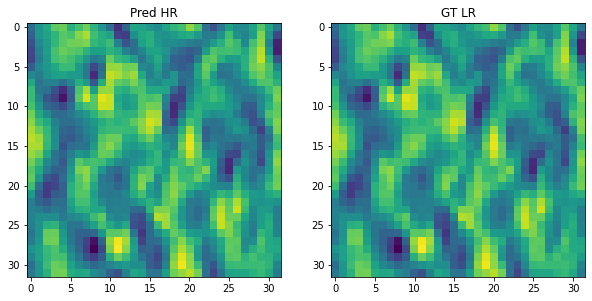

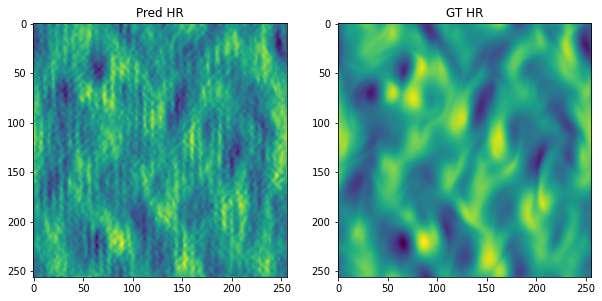

In [8]:
X_lr, y_lr = dm.val_dataset[:]
img_shape_lr = dm.val_dataset.img_shape[:2]
shape_lr = dm.val_dataset.img_shape

X_hr, y_hr = dm.test_dataset[:]
img_shape_hr = dm.test_dataset.img_shape[:2]
shape_hr = dm.test_dataset.img_shape

print(X_lr.shape, y_lr.shape)
print(X_hr.shape, y_hr.shape)

y_hat_lr, P_hat_lr = model(X_lr)
y_hat_hr, P_hat_hr = model(X_hr)

print(y_hat_lr.shape)
print(y_hat_hr.shape)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('Pred HR')
plt.imshow(y_hat_lr[:,0].reshape(*img_shape_lr).detach())
plt.subplot(122)
plt.title('GT LR')
plt.imshow(y_lr[:,0].reshape(*img_shape_lr).detach())
plt.show()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.title('Pred HR')
plt.imshow(y_hat_hr[:,0].reshape(*img_shape_hr).detach())
plt.subplot(122)
plt.title('GT HR')
plt.imshow(y_hr[:,0].reshape(*img_shape_hr).detach())
plt.show()

In [9]:
from kornia.filters import SpatialGradient
sp_grad = SpatialGradient(mode='diff',normalized=True)

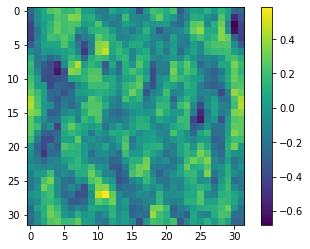

In [10]:
res = 32
x = torch.linspace(0, 1, res, device=model.device)
xx, xy = torch.meshgrid([x, x])
x = torch.cat([xx.flatten()[:,None], xy.flatten()[:,None]], dim=-1)
x.requires_grad_(True)
y_hat_off, _ = model.forward(x)

plt.imshow(y_hat_off[:,0].reshape(res,res).detach())
plt.colorbar()
plt.show()

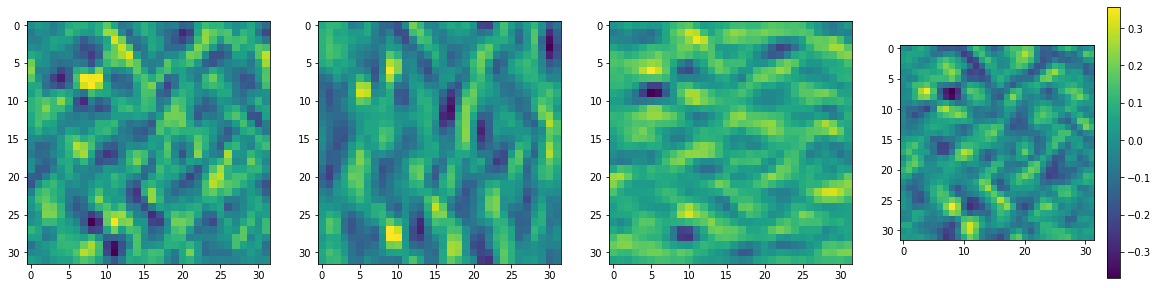

In [11]:
# compute the spatial gradient of the groundtruth
y_img_hat = y_lr.view(1,res,res,2).permute(0,3,1,2)
grads = sp_grad(y_img_hat)
img_u_x = grads[0,0,1,...] # we take this inverted as it was we are doing ij indexing
img_u_y = grads[0,0,0,...] # we take this inverted as it was we are doing ij indexing
img_v_x = grads[0,1,1,...] # we take this inverted as it was we are doing ij indexing
img_v_y = grads[0,1,0,...] # we take this inverted as it was we are doing ij indexing

plt.figure(figsize=(20,5))
plt.subplot(141)
plt.imshow(img_u_x.detach())
plt.subplot(142)
plt.imshow(img_u_y.detach())
plt.subplot(143)
plt.imshow(img_v_x.detach())
plt.subplot(144)
plt.imshow(img_v_y.detach())
plt.colorbar()
plt.show()

# compute the spatial gradient of the prediction
y_img_hat = y_hat_off.view(1,res,res,2).permute(0,3,1,2)
grads = sp_grad(y_img_hat)
img_u_x = grads[0,0,1,...] # we take this inverted as it was we are doing ij indexing
img_u_y = grads[0,0,0,...] # we take this inverted as it was we are doing ij indexing
img_v_x = grads[0,1,1,...] # we take this inverted as it was we are doing ij indexing
img_v_y = grads[0,1,0,...] # we take this inverted as it was we are doing ij indexing

plt.figure(figsize=(20,5))
plt.subplot(141)
plt.imshow(img_u_x.detach())
plt.subplot(142)
plt.imshow(img_u_y.detach())
plt.subplot(143)
plt.imshow(img_v_x.detach())
plt.subplot(144)
plt.imshow(img_v_y.detach())
plt.colorbar()
plt.show()

# compute the gradient of the prediction with autograd
u, v = torch.split(y_hat_off,1,-1)
du_xy = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
dv_xy = torch.autograd.grad(v, x, torch.ones_like(v), create_graph=True)[0]

du_x = du_xy[:,0].reshape(res,res) / 32
du_y = du_xy[:,1].reshape(res,res) / 32
dv_x = dv_xy[:,0].reshape(res,res) / 32
dv_y = dv_xy[:,1].reshape(res,res) / 32

plt.figure(figsize=(20,5))
plt.subplot(141)
plt.imshow(du_x.detach())
plt.subplot(142)
plt.imshow(du_y.detach())
plt.subplot(143)
plt.imshow(dv_x.detach())
plt.subplot(144)
plt.imshow(dv_y.detach())
plt.colorbar()
plt.show()

gdiff_u_x = torch.abs(img_u_x - du_x)**1
gdiff_u_y = torch.abs(img_u_y - du_y)**1
gdiff_v_x = torch.abs(img_v_x - dv_x)**1
gdiff_v_y = torch.abs(img_v_y - dv_y)**1

plt.figure(figsize=(20,5))
plt.subplot(141)
plt.imshow(gdiff_u_x.detach().cpu())
plt.subplot(142)
plt.imshow(gdiff_u_y.detach().cpu())
plt.subplot(143)
plt.imshow(gdiff_v_x.detach().cpu())
plt.subplot(144)
plt.imshow(gdiff_v_y.detach().cpu())
plt.colorbar()
plt.show()

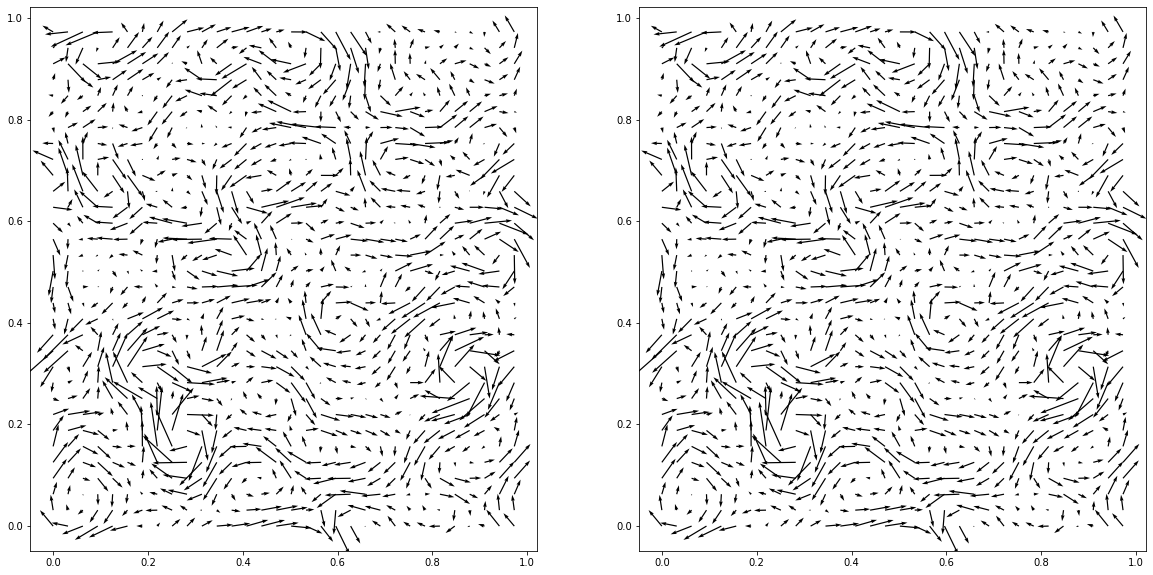

In [15]:
x = X_lr[:,0].detach()
y = X_lr[:,1].detach()
u = y_hat_lr[:,0].detach()
v = y_hat_lr[:,1].detach()

s = 1
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.quiver(x.reshape(*img_shape_lr)[::s,::s], 
           y.reshape(*img_shape_lr)[::s,::s],
           u.reshape(*img_shape_lr)[::s,::s],
           v.reshape(*img_shape_lr)[::s,::s], scale=10)
plt.subplot(122)
plt.quiver(        x.reshape(*img_shape_lr)[::s,::s], 
                   y.reshape(*img_shape_lr)[::s,::s],
           y_lr[:,0].reshape(*img_shape_lr)[::s,::s],
           y_lr[:,1].reshape(*img_shape_lr)[::s,::s], scale=10)

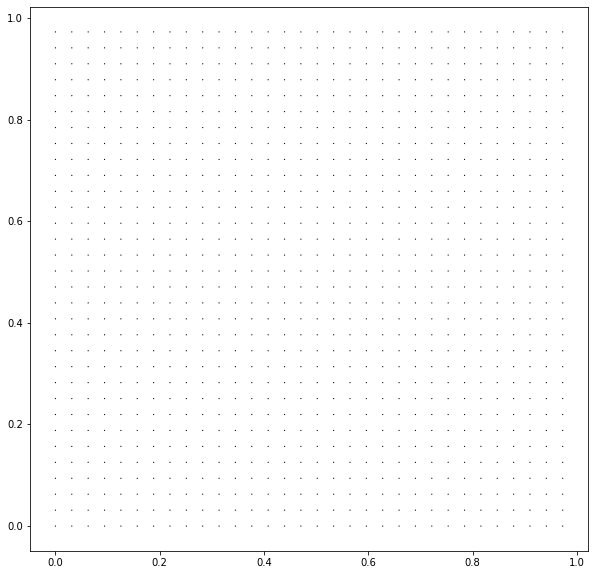

In [16]:
x = X_lr[:,0].detach()
y = X_lr[:,1].detach()
u_diff = y_hat_lr[:,0].detach() - y_lr[:,0].detach()
v_diff = y_hat_lr[:,1].detach() - y_lr[:,1].detach()

s = 1
plt.figure(figsize=(10,10))
plt.quiver(x.reshape(*img_shape_lr)[::s,::s], 
           y.reshape(*img_shape_lr)[::s,::s],
           u_diff.reshape(*img_shape_lr)[::s,::s],
           v_diff.reshape(*img_shape_lr)[::s,::s], scale=10)

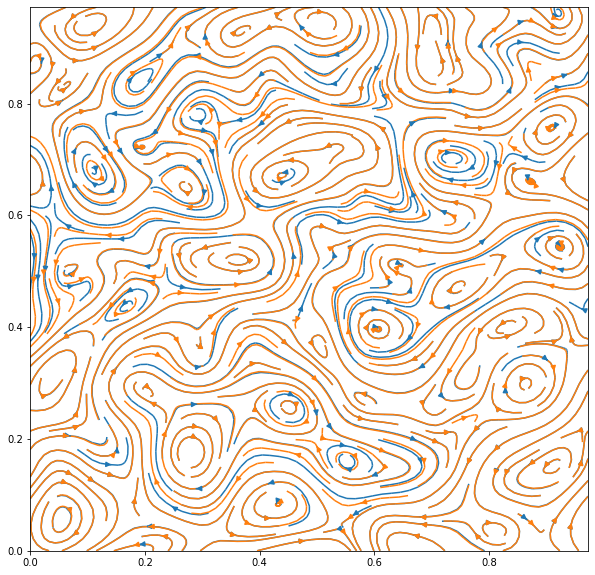

In [17]:
s = 1
plt.figure(figsize=(10,10))
plt.streamplot(        
           x.reshape(*img_shape_lr)[::s,::s].T.numpy(), 
           y.reshape(*img_shape_lr)[::s,::s].T.numpy(),
           y_lr[:,0].reshape(*img_shape_lr)[::s,::s].T.numpy(),
           y_lr[:,1].reshape(*img_shape_lr)[::s,::s].T.numpy(), density=2)
plt.streamplot(x.reshape(*img_shape_lr)[::s,::s].T.numpy(), 
           y.reshape(*img_shape_lr)[::s,::s].T.numpy(),
           u.reshape(*img_shape_lr)[::s,::s].T.numpy(),
           v.reshape(*img_shape_lr)[::s,::s].T.numpy(), density=2)

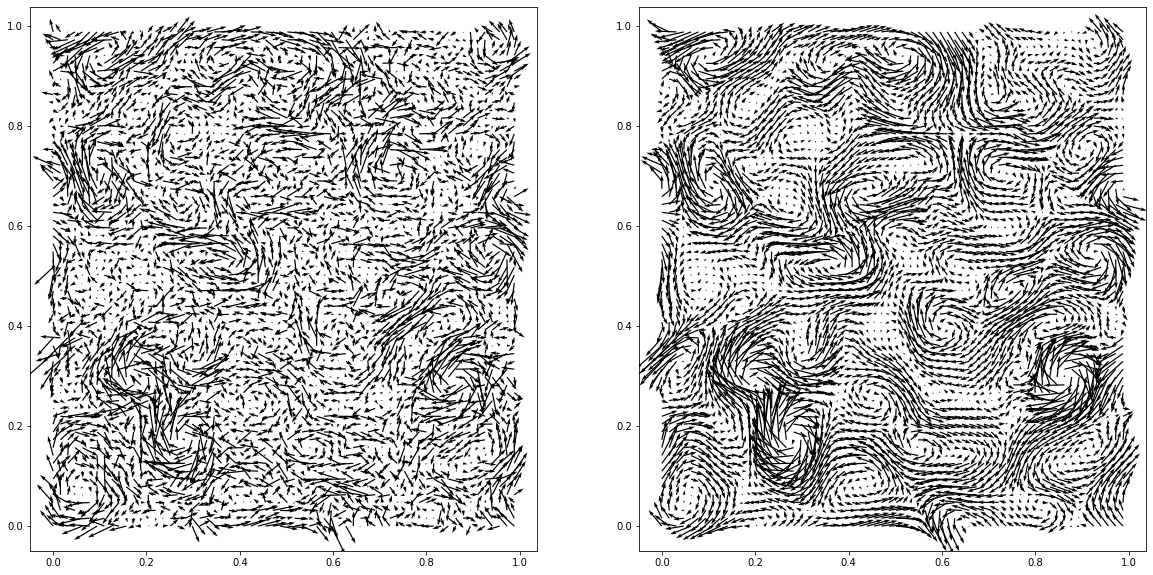

In [18]:
x = X_hr[:,0].detach()
y = X_hr[:,1].detach()
u = y_hat_hr[:,0].detach()
v = y_hat_hr[:,1].detach()

s = 4
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.quiver(x.reshape(*img_shape_hr)[::s,::s], 
           y.reshape(*img_shape_hr)[::s,::s],
           u.reshape(*img_shape_hr)[::s,::s],
           v.reshape(*img_shape_hr)[::s,::s], scale=10)
plt.subplot(122)
plt.quiver(        x.reshape(*img_shape_hr)[::s,::s], 
                   y.reshape(*img_shape_hr)[::s,::s],
           y_hr[:,0].reshape(*img_shape_hr)[::s,::s],
           y_hr[:,1].reshape(*img_shape_hr)[::s,::s], scale=10)

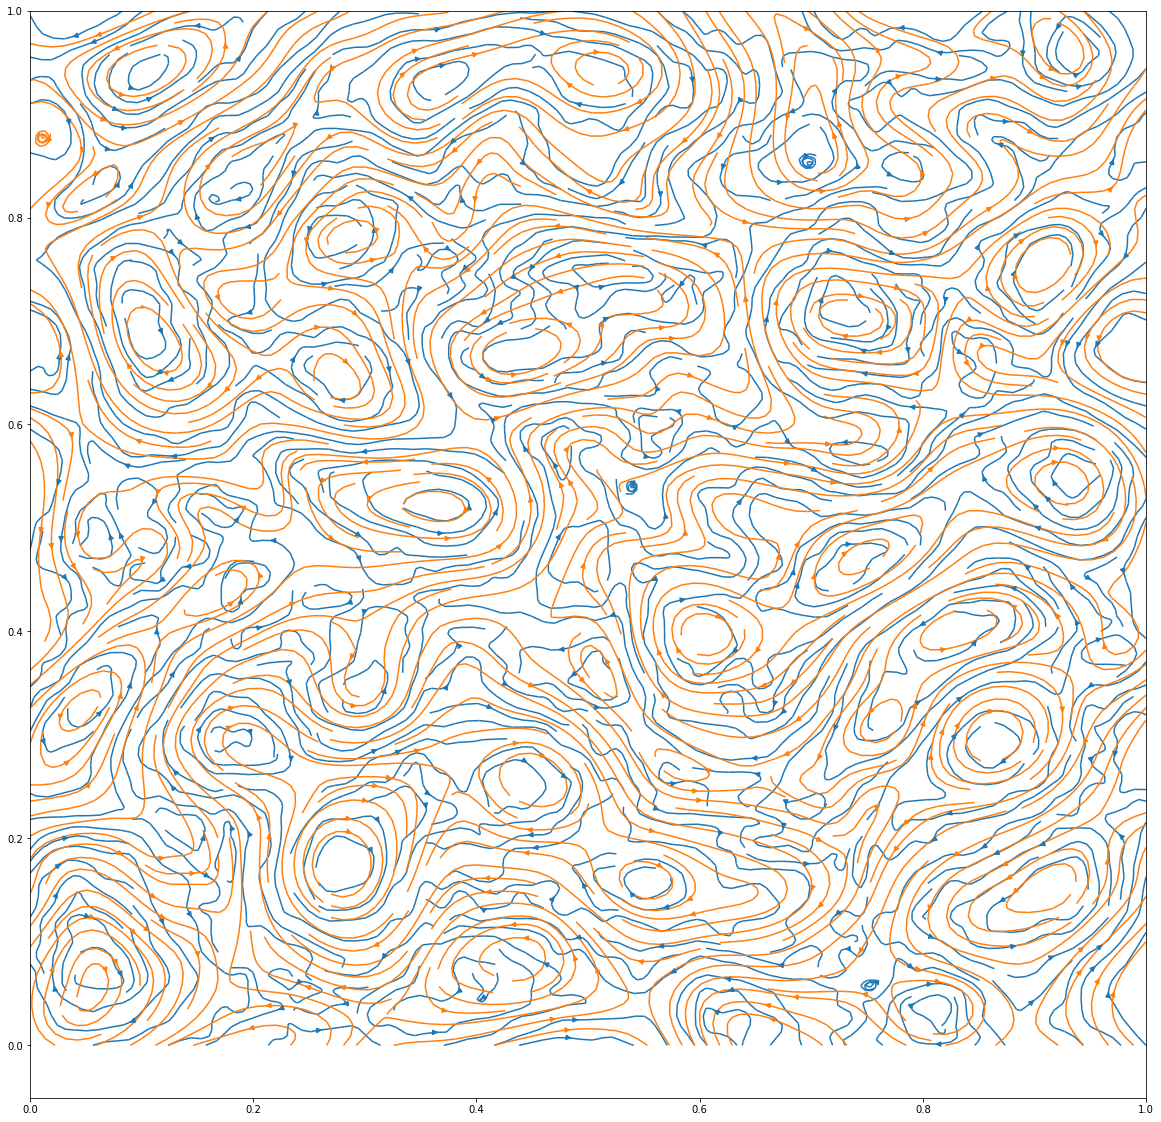

In [19]:
s = 1
plt.figure(figsize=(20,20))
plt.streamplot(
           x.reshape(*img_shape_hr)[::s,::s].T.numpy(), 
           y.reshape(*img_shape_hr)[::s,::s].T.numpy(),
           u.reshape(*img_shape_hr)[::s,::s].T.numpy(),
           v.reshape(*img_shape_hr)[::s,::s].T.numpy(),density=3)
plt.streamplot(        
           x.reshape(*img_shape_hr)[::s,::s].T.numpy(), 
           y.reshape(*img_shape_hr)[::s,::s].T.numpy(),
           y_hr[:,0].reshape(*img_shape_hr)[::s,::s].T.numpy(),
           y_hr[:,1].reshape(*img_shape_hr)[::s,::s].T.numpy(),density=3)

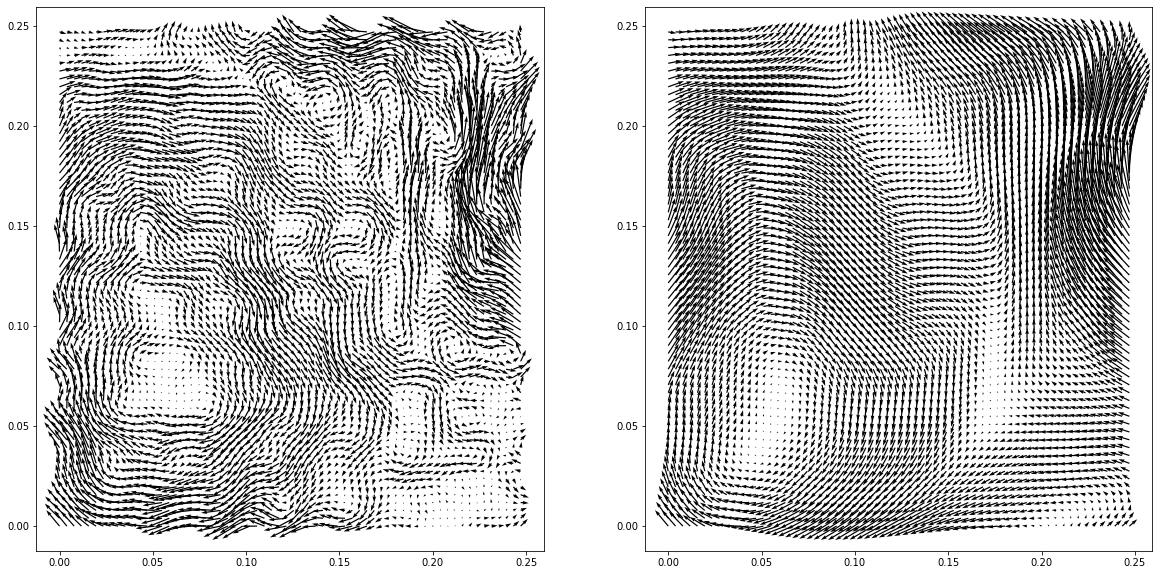

In [20]:
x = X_hr[:,0].detach()
y = X_hr[:,1].detach()
u = y_hat_hr[:,0].detach()
v = y_hat_hr[:,1].detach()

d = 1
l = 64
s = 10
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.quiver(x.reshape(*img_shape_hr)[:l:d,:l:d], 
           y.reshape(*img_shape_hr)[:l:d,:l:d],
           u.reshape(*img_shape_hr)[:l:d,:l:d],
           v.reshape(*img_shape_hr)[:l:d,:l:d], scale=s)
plt.subplot(122)
plt.quiver(        x.reshape(*img_shape_hr)[:l:d,:l:d], 
                   y.reshape(*img_shape_hr)[:l:d,:l:d],
           y_hr[:,0].reshape(*img_shape_hr)[:l:d,:l:d],
           y_hr[:,1].reshape(*img_shape_hr)[:l:d,:l:d], scale=s)

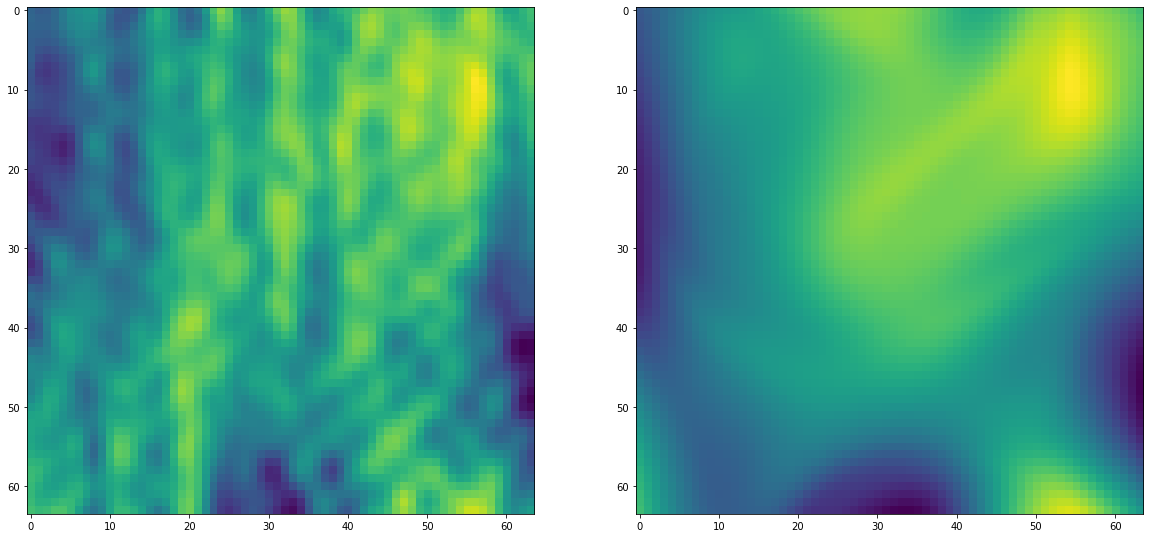

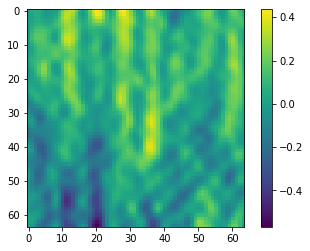

In [21]:
x = X_hr[:,0].detach()
y = X_hr[:,1].detach()
u = y_hat_hr[:,0].detach()
v = y_hat_hr[:,1].detach()

d = 1
l = 64
s = 10
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(u.reshape(*img_shape_hr)[:l:d,:l:d])
plt.subplot(122)
plt.imshow(y_hr[:,0].reshape(*img_shape_hr)[:l:d,:l:d])
plt.show()
plt.imshow((y_hr[:,0]-u).reshape(*img_shape_hr)[:l:d,:l:d])
plt.colorbar()

In [22]:
print(compute_all_metrics(y_hat_lr, y_lr))
print(compute_all_metrics(y_hat_hr, y_hr))

{'reconstruction': 6.939649210835341e-06, 'angular_degree': 0.12338431924581528, 'log_err_specturm': 0.0012820735573768616}
{'reconstruction': 0.038747821003198624, 'angular_degree': 8.697174072265625, 'log_err_specturm': 61.47719192504883}


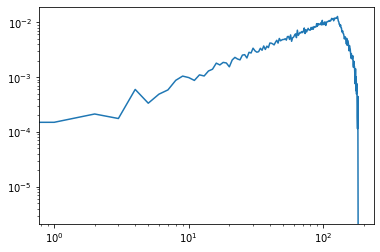

In [23]:
spec_ns, k_ns = phy.energy_spectrum(torch.randn(*shape_hr).permute(2,0,1))

plt.loglog(k_ns, spec_ns)

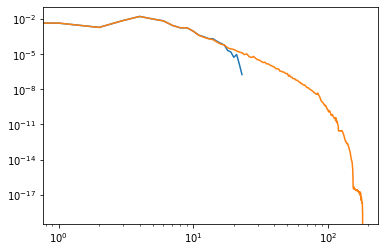

In [24]:
# compute spectrum
spec_ns = phy.energy_spectrum(torch.randn(*shape_hr).permute(2,0,1))[0]
spec_lr, k_lr = phy.energy_spectrum(y_lr.view(*shape_lr).permute(2,0,1))
spec_hr, k_hr = phy.energy_spectrum(y_hr.view(*shape_hr).permute(2,0,1))

# plt.loglog(spec_ns)
plt.loglog(k_lr, spec_lr)
plt.loglog(k_hr, spec_hr)

# torch.save(spec_hr, '../data/hr_spect128.pt')

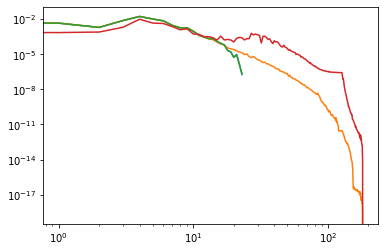

In [25]:
# compute spectrum
spec_ns = phy.energy_spectrum(torch.randn(*shape_hr).permute(2,0,1))[0]
spec_lr = phy.energy_spectrum(y_lr.view(*shape_lr).permute(2,0,1))[0]
spec_hr = phy.energy_spectrum(y_hr.view(*shape_hr).permute(2,0,1))[0]

spec_lr_pred = phy.energy_spectrum(y_hat_lr.view(*shape_lr).permute(2,0,1))[0]
spec_hr_pred = phy.energy_spectrum(y_hat_hr.view(*shape_hr).permute(2,0,1))[0]

# plt.loglog(spec_ns)
plt.loglog(spec_lr)
plt.loglog(spec_hr)
plt.loglog(spec_lr_pred.detach())
plt.loglog(spec_hr_pred.detach())


In [26]:
# spec error
spec_log_error_lr = torch.norm(torch.log(spec_lr_pred+1e-20) - torch.log(spec_lr+1e-20))**2
spec_log_error_hr = torch.norm(torch.log(spec_hr_pred+1e-20) - torch.log(spec_hr+1e-20))**2

print(spec_error_lr.item())
print(spec_error_hr.item())

NameError: name 'spec_error_lr' is not defined

In [27]:
# angular error
def ang_error(x, x_ref, avg=True):
    assert x.shape == x_ref.shape
    assert x.shape[1] == 2
    N = x.shape[0]
    
    w1 = torch.cat([x, torch.ones(x.shape[0], 1)], dim=1)
    w2 = torch.cat([x_ref, torch.ones(x_ref.shape[0], 1)], dim=1)
    
    err = torch.sum(w1 * w2, dim=1) / (torch.norm(w1, dim=1) * torch.norm(w2, dim=1))
    assert err.sum() < N
    err = torch.rad2deg(torch.acos(err))
    if avg:
        return err.mean()
    return err
    

ang_err_lr = ang_error(y_lr, y_hat_lr, avg=True)
ang_err_hr = ang_error(y_hr, y_hat_hr, avg=True)

print(torch.max(ang_error(y_lr, y_hat_lr, avg=False)))
print(torch.max(ang_error(y_hr, y_hat_hr, avg=False)))


tensor(nan, grad_fn=<MaxBackward1>)
tensor(nan, grad_fn=<MaxBackward1>)


In [28]:
model = plDivFreeRFFNet.load_from_checkpoint(checkpoint_callback.best_model_path)
trainer.test(model, dm)

/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/dicarlo_d/Documents/Code/TurboSuperResultion/venv/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

KeyboardInterrupt: 

In [29]:
spec_lr_err = phy.energy_spectrum(((y_hat_lr-y_lr)**2).view(*img_shape_lr).permute(2,0,1))[0]
spec_hr_err = phy.energy_spectrum(((y_hat_hr-y_hr)**2).view(*img_shape_hr).permute(2,0,1))[0]

plt.loglog(spec_lr_err.detach())
plt.loglog(spec_hr_err.detach())

RuntimeError: shape '[32, 32]' is invalid for input of size 2048

In [30]:
y_hat, Py_hat = model(X_lr)
u, v = torch.split(y_hat,1,-1)
du_xy = torch.autograd.grad(u, X_lr, torch.ones_like(u), create_graph=True)[0]       
dv_xy = torch.autograd.grad(v, X_lr, torch.ones_like(v), create_graph=True)[0]
# div_autograd = du_xy[...,0] + dv_xy[...,1]
div_autograd = dv_xy[...,1]
div_autograd = div_autograd.view(*img_shape_lr[:2])

plt.imshow(div_autograd.detach())
plt.colorbar()
plt.show()

du_x = tch._my_field_grad(y_hat.view(*img_shape_lr)[:,:,0], 1)
du_y = tch._my_field_grad(y_hat.view(*img_shape_lr)[:,:,1], 0)
div_numerical = du_y
    
plt.imshow(div_numerical.detach())
plt.colorbar()
plt.show()

plt.imshow((div_numerical - div_autograd).detach())
plt.colorbar()
plt.show()


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking arugment for argument mat1 in method wrapper_addmm)

In [31]:
y_hat, Py_hat = model(X_hr)
u, v = torch.split(y_hat,1,-1)
du_xy = torch.autograd.grad(u, X_hr, torch.ones_like(u), create_graph=True)[0]       
dv_xy = torch.autograd.grad(v, X_hr, torch.ones_like(v), create_graph=True)[0]
# div_autograd = du_xy[...,0] + dv_xy[...,1]
div_autograd = dv_xy[...,1]
div_autograd = div_autograd.view(*img_shape_hr[:2])

plt.imshow(div_autograd[2:-2,2:-2].detach())
plt.colorbar()
plt.show()

du_x = tch._my_field_grad(y_hat.view(*img_shape_hr)[:,:,0], 1)
du_y = tch._my_field_grad(y_hat.view(*img_shape_hr)[:,:,1], 0)
div_numerical = du_y
    
plt.imshow(div_numerical[2:-2,2:-2].detach())
plt.colorbar()
plt.show()

plt.imshow((div_numerical[2:-2,2:-2] - div_autograd[2:-2,2:-2]).detach())
plt.colorbar()
plt.show()


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking arugment for argument mat1 in method wrapper_addmm)